### ADA-II – HW4 - Team 1 - 04/44/2022
Jen Arriaza (Lead) - 65%<br>
Junyu (Eric) Lin - 35%<br>
Byron Liu - 0%<br>
**Algorithms**: Singular Value Decompisition (SVD)<br>
**Course**: Applied Data Analytics II, 2022 Spring<br>
**Professor**: Stavros Zervoudakis

#### Problem Statement:
Using Ra

In [14]:
import sys
!{sys.executable} -mpip install opencv-python

     |████████████████████████████████| 46.3 MB 10.1 MB/s eta 0:00:01    |█████████████▍                  | 19.4 MB 3.4 MB/s eta 0:00:08


In [20]:
!{sys.executable} -mpip install scikit-surprise

     |████████████████████████████████| 11.8 MB 756 kB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp38-cp38-macosx_10_9_x86_64.whl size=766876 sha256=b3b62bdb661ec27044a0c7db9373f4ef83c94c51d79221bc84daf680a5ef8df2
  Stored in directory: /Users/jenarriaza/Library/Caches/pip/wheels/20/91/57/2965d4cff1b8ac7ed1b6fa25741882af3974b54a31759e10b6
Successfully built scikit-surprise


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
import sys
import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns
import pandas as pd
import os
import cv2

import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "png"

# Ignore printing warnings for general readability
import warnings 
warnings.filterwarnings("ignore")

# pip install scikit-surprise
# Importing libraries for model building & evaluation
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import SVD
from surprise import accuracy

In [17]:
os.getcwd()

'/Users/jenarriaza/Applied Data Analytics-II'

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/yasserh/wine-quality-dataset")

In [18]:
df = pd.read_csv('WineQT.csv')

### Exploring WineQT dataset

In [22]:
df.shape

(1143, 13)

There are 1,143 rows and 13 columns

In [23]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2


In [24]:
# Check datatypes & missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [25]:
# Check for duplicate values
print(f'Duplicate entries: {df.duplicated().sum()}')

Duplicate entries: 0


No missing values or duplicate exist in dataset

In [29]:
# Rename columns to a more readable format
df.rename(columns = {'fixed acidity': 'fixed_acidity', 'volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'residual sugar': 'residual_sugar'}, inplace=True)

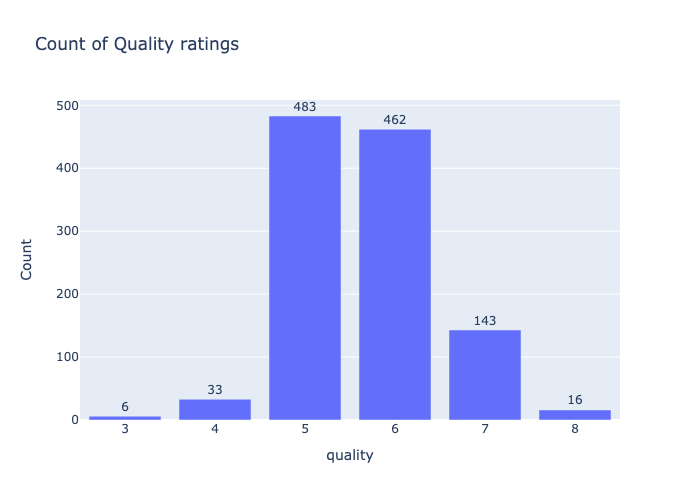

In [26]:
# Visualizing column of interest: quality

quality_ratings = df['quality'].value_counts()
x,y   = quality_ratings.index, quality_ratings.values
data  = go.Bar(x=x,y=y, text=y, textposition="outside")
Layout=go.Layout(title="Count of Quality ratings",xaxis={'title':'quality'},yaxis={'title':'Count'})
go.Figure(data,Layout)

- Highest rating for quality is 10, lowest is 3
- Quality rating of '5' has the highest quality rating count among all

[Text(0.5, 1.0, 'Quality')]

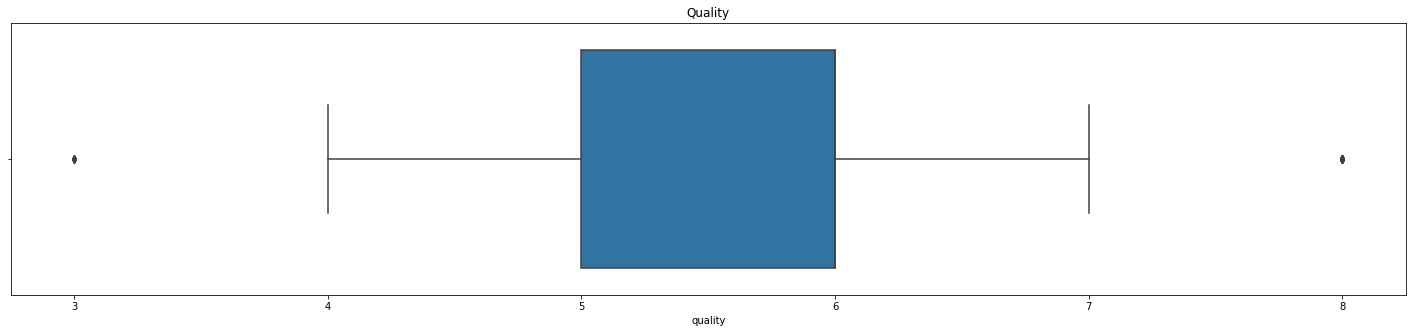

In [30]:
#  Visualize fixed & volatile acidity data
plt.figure(figsize=(25,5))
sns.boxplot(x='quality', data=df).set(title='Quality')

<AxesSubplot:>

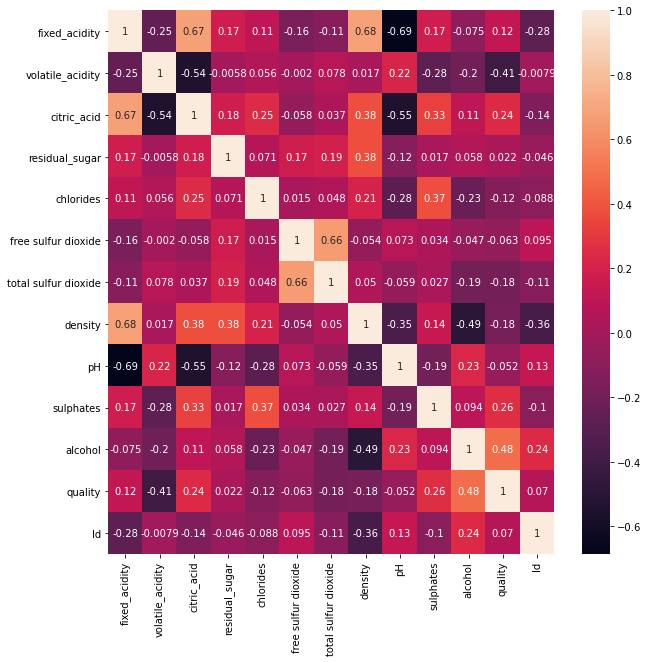

In [37]:
# Create correlation heatmap

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),color='k', annot=True)

- None of the features indicate high correlation to quality.
- Alcohol and sulphates indicate some possible moderate positive correlation, while acidity indicates similar results but negative.

### Machine Learning: Setup test/train data and create object

In [43]:
# creating a surprise object

reader = Reader(rating_scale=(0, 10))
data  = Dataset.load_from_df(df[['Id','quality','alcohol']], reader)


# Split the data into training & testing sets. Python's surprise documentation has the steps detailed out
# https://surprise.readthedocs.io/en/stable/FAQ.html

raw_ratings = data.raw_ratings
import random
random.shuffle(raw_ratings)                 # shuffle dataset

threshold   = int(len(raw_ratings)*0.8)

train_raw_ratings = raw_ratings[:threshold] # 80% of data is trainset
test_raw_ratings  = raw_ratings[threshold:] # 20% of data is testset

data.raw_ratings = train_raw_ratings        # data is now the trainset
trainset         = data.build_full_trainset() 
testset          = data.construct_testset(test_raw_ratings)

# Singular Value Decompisition
- The algorithm will take a matrix factorization approach. The quality ratig is factorized into smaller dimensions consisting of latent factors (set to 100 by default). The latent factors can capture the known quality ratings, and then able to predict an estimated quality rating for a scenario where an attribute is unknown or unavailable.

In [45]:
# Trying SVD (Singluar Value decomposition) algorithm using default model parameters

models=[SVD()] 
results = {}

for model in models:
    # perform 5 fold cross validation
    # evaluation metrics: mean absolute error & root mean square error
    CV_scores = cross_validate(model, data, measures=["MAE","RMSE"], cv=5, n_jobs=-1)  
    
    # storing the average score across the 5 fold cross validation for each model
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result

#### Assessing model performance

In [46]:
performance_df = pd.DataFrame.from_dict(results)
print("Model Performance: \n")
performance_df.T.sort_values(by='RMSE')

Model Performance: 



,MAE,RMSE,fit_time,test_time
matrix_factorization.SVD,0.867616,1.170416,0.075181,0.001196


In [47]:
# Hyperparameter tuning - SVD

param_grid = {"n_factors": range(10,100,20),
              "n_epochs" : [5, 10, 20],
              "lr_all"   : [0.002, 0.005],
              "reg_all"  : [0.2, 0.5]}

gridsearchSVD = GridSearchCV(SVD, param_grid, measures=['mae', 'rmse'], cv=5, n_jobs=-1)
                                    
gridsearchSVD.fit(data)

print(f'MAE Best Parameters:  {gridsearchSVD.best_params["mae"]}')
print(f'MAE Best Score:       {gridsearchSVD.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchSVD.best_params["rmse"]}')
print(f'RMSE Best Score:      {gridsearchSVD.best_score["rmse"]}\n')

MAE Best Parameters:  {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.2}
MAE Best Score:       0.8754850868520008

RMSE Best Parameters: {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.2}
RMSE Best Score:      1.1706594374934416



- Hyperparameter tuning with GridSearchCV package finds best parameters using RMSE and MAE metrics
- for SVD, n_factors=10, n_epochs=5, lr_all=0.005, reg_all= 0.2 are chosen for the model

In [48]:
# Model fit & prediction - SVD

final_model = SVD(n_factors=10, n_epochs=5, lr_all=0.005, reg_all= 0.2)

# Fitting the model on trainset & predicting on testset, printing test accuracy
pred = final_model.fit(trainset).test(testset)

print(f'\nUnbiased Testing Performance')
print(f'MAE: {accuracy.mae(pred)}, RMSE: {accuracy.rmse(pred)}')


Unbiased Testing Performance
MAE:  0.8887
RMSE: 1.1530
MAE: 0.8887315280561773, RMSE: 1.152977882471079


* The metrics MAE and RMSE for the test set are similar to results obtained from hyperparamter tuning stages.
* The result indicates that the model generalizes well (no over-fit or under-fit)

In [55]:
# SVD

def generate_levels(Id=1, get_recommend =5):
    
    ''' This function generates recommended level of features
        using Singular value decomposition. The function needs as input two 
        different parameters:
        (1) uid i.e., Id for which  levels need to be generated 
        (2) generate_levels i.e., levels to generate for the Id
        Default values are: Id=1, generate_levels=5
    '''
    
    model = SVD(n_factors=10, n_epochs=5, lr_all=0.005, reg_all= 0.2)
    model.fit(trainset)
    
    # predict rating for all pairs of users & items that are not in the trainset
    
    testset = trainset.build_anti_testset()
    predictions = model.test(testset)
    predictions_df = pd.DataFrame(predictions)
    
    # get the top get_recommend predictions for userID
    
    predictions_Id = predictions_df[predictions_df['uid'] == Id].\
                         sort_values(by="est", ascending = False).head(get_recommend)
    
    recommendations = []
    recommendations.append(list(predictions_Id['iid']))
    recommendations = recommendations[0]
    
    return(recommendations)

In [56]:
recommendationsSVD = generate_levels(Id=1, get_recommend =5)
recommendationsSVD

[7, 6, 4, 8, 3]

#### Conclusion
- We have implemented a SVD method based approach to make recommended levels of red wine attributes. The SVD gives the ratio of the between-within group standard deviations on the linear discriminant variables. This could be useful for instances with a potential new wine product where little is known of customers preference.